## feature engineering: 
- smoothness of oscillator curves
- smoothness of price curves
- smoothness of MACD curves
- price percentage change compared to day #0
- oscillator absolute values change compared to day #0 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import normalize
import spectrum
from spectrum import Periodogram, data_cosine

In [42]:
def cal_smoothness(data, type): 
    smoothness = []
    for i in range(data.shape[0]):
        smth = np.std(list(data.iloc[i, :] - data.iloc[i, :].shift(1))[1:])
        smoothness.append(smth)
    return pd.Series(smoothness, name=type + '_smth', index=data.index)

In [44]:
def read_data_files():
    data = pd.DataFrame()
    
    for filename in os.listdir('../data/buy/'):
        if filename.endswith(".txt"): 
            tmp_df = pd.read_csv(os.path.join('../data/buy/', filename), delimiter= '\s+', header = None)
            tmp_df = tmp_df.astype(float)
            # symbol = filename.split("1")[0]
            # tmp_df = pd.concat([pd.Series([symbol] * tmp_df.shape[0], name = 'symbol'), tmp_df], axis=1)
            tmp_df = tmp_df.iloc[20:,:]
            data = pd.concat([data, tmp_df])
    
    # remove duplicates 
    data = data.drop_duplicates()
    
    # remove extreme oscillator values 
    data = data[(data[0] > -7) & (data[0] < 7)] 
    
    # remove positive oscillator values
    # data = data[data[0] < 0]
    
    # reset index 
    data = data.reset_index(drop=True)
    
    # set column names 
    osc_names = ['osc' + str(i) for i in range(41)]
    prc_names = ['prc' + str(i) for i in range(41)]
    macd_names = ['macd' + str(i) for i in range(41)]
    data.columns = osc_names + prc_names + macd_names + ['rtn']
    
    # preprocess oscillator data 
    osc_data = data.iloc[:, :41].reset_index(drop=True)
    osc_data = osc_data[osc_data.columns[::-1]]
    for i in range(osc_data.shape[0]):
        osc_data.iloc[i, :] = osc_data.iloc[i, :] - osc_data.iloc[i, -1] 
    
    # preprocess price data 
    prc_data = data.iloc[:, 41:82].reset_index(drop=True)
    prc_data = prc_data[prc_data.columns[::-1]]
    for i in range(prc_data.shape[0]):
        prc_data.iloc[i, :] = prc_data.iloc[i, :]/prc_data.iloc[i, -1]
    
    # preprocess MACD data 
    macd_data = data.iloc[:, 82:123].reset_index(drop=True)
    macd_data = macd_data[macd_data.columns[::-1]]
    # macd_data = normalize_data(macd_data) 
    
    # add smoothness features 
    osc_smth = cal_smoothness(osc_data, 'osc')
    prc_smth = cal_smoothness(prc_data, 'prc')
    macd_smth = cal_smoothness(macd_data, 'macd')
    
    rtn = data['rtn'].reset_index(drop=True)
    label = pd.Series(map(lambda x: 1 if x>0 else 0, rtn), name = 'label')
    
    data = pd.concat([osc_data, prc_data, macd_data, osc_smth, prc_smth, macd_smth, rtn, label], axis=1)
    data = data.reset_index(drop=True)
    
    return data

In [10]:
def standardize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - np.mean(row))/np.std(row) 
    return data 

In [11]:
def normalize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - min(row))/(max(row) - min(row)) 
    return data

In [18]:
class StockData():
    def __init__(self, data):
        
        # balance the data set 
        pos_data = data[data['label'] == 1]
        neg_data = data[data['label'] == 0]
        if pos_data.shape[0] > neg_data.shape[0]:
            pos_data = pos_data.sample(neg_data.shape[0])
        else:
            neg_data = neg_data.sample(pos_data.shape[0])
        data = pd.concat([pos_data, neg_data], axis = 0)
        data = data.reset_index(drop = True) 
        
        X = data.iloc[:, :-1]
        y = data['label']
        
        X_train_valid_w_rtn, X_test_w_rtn, y_train_valid, y_test = train_test_split(X, y, test_size=0.25) 
        # train_valid set
        self.train_valid_rtn = X_train_valid_w_rtn['rtn']
        self.X_train_valid = X_train_valid_w_rtn.drop(['rtn'], axis = 1)
        self.y_train_valid = y_train_valid
        
        X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(X_train_valid_w_rtn, y_train_valid, test_size=0.25) 
        # training set 
        self.train_rtn = X_train_w_rtn['rtn'] 
        self.X_train = X_train_w_rtn.drop(['rtn'], axis = 1)
        self.y_train = y_train
        # validation set
        self.valid_rtn = X_valid_w_rtn['rtn']
        self.X_valid = X_valid_w_rtn.drop(['rtn'], axis = 1) 
        self.y_valid = y_valid
        # test set 
        self.test_rtn = X_test_w_rtn['rtn']
        self.X_test = X_test_w_rtn.drop(['rtn'], axis = 1)        
        self.y_test = y_test 

In [6]:
class SeahorseBuyModel(): 
    def __init__(self):
        self.clf = RandomForestClassifier(n_estimators = 32, max_depth = 50)
        self.features = []
        return 
    
    def fit(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
        self.features = X_train.columns
        return
    
    def score(self, X, y):
        return self.clf.score(X, y)
    
    def evaluate(self, X, y, rtn):
        probs = self.clf.predict_proba(X)

        win_probs = []
        for i in range(len(probs)):
            win_probs.append(probs[i][1])

        trade_classes = [int(x * 10)/10 for x in win_probs]
            
        results = pd.concat([pd.Series(win_probs, name='win_prob'), 
                             pd.Series(trade_classes, name='trade_class'), 
                             y.reset_index(drop=True), 
                             rtn.reset_index(drop=True)], 
                            axis = 1)

        summary = pd.concat([results.groupby(['trade_class']).mean(), 
                             results.groupby(['trade_class']).count()['win_prob'], 
                             100 * results.groupby(['trade_class']).count()['win_prob']/results.shape[0]], 
                            axis=1)
        summary.columns = ['predicted win prob', 'actual win rate', 'mean return', '# of trades', '% of all trades']
        # summary = summary.reindex([i/10 for i in range(10)])
        print(summary.to_string())
        return 
    
    def feature_importances(self):
        f = {'f_name': list(self.features), 
             'f_importance': list(self.clf.feature_importances_)}
        f = pd.DataFrame(f)
        f = f.sort_values(by=['f_importance'], ascending=False)
        return f

In [45]:
data = read_data_files()

In [46]:
data.to_csv('../data/data_RF2.csv')

In [47]:
data.head()

,osc40,osc39,osc38,osc37,osc36,osc35,osc34,osc33,osc32,osc31,...,macd4,macd3,macd2,macd1,macd0,osc_smth,prc_smth,macd_smth,rtn,label
0,-6.55,-8.28,-10.84,-13.15,-14.86,-15.30,-15.65,-15.42,-15.31,-15.52,...,0.07,0.10,0.11,0.14,0.14,0.980134,0.025621,0.036516,-1.06,0
1,-13.18,-14.89,-15.33,-15.68,-15.45,-15.34,-15.55,-14.57,-13.82,-13.33,...,0.14,0.14,0.13,0.11,0.10,0.714216,0.025134,0.037382,-0.53,0
2,-15.83,-16.18,-15.95,-15.84,-16.05,-15.07,-14.32,-13.83,-13.19,-12.56,...,0.13,0.11,0.10,0.08,0.08,0.627761,0.024765,0.038006,-5.32,0
3,2.07,2.69,3.45,4.04,4.55,4.18,3.22,1.90,0.62,-1.14,...,0.01,0.02,0.01,0.01,0.00,1.407599,0.023730,0.045233,-0.56,0
4,3.17,3.76,4.27,3.90,2.94,1.62,0.34,-1.42,-3.28,-5.32,...,0.01,0.01,0.00,-0.01,-0.01,1.398443,0.023767,0.045249,-5.03,0


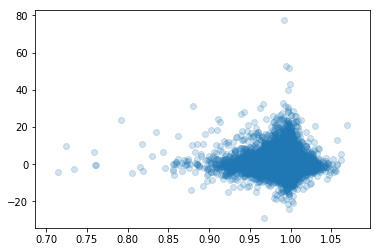

In [66]:
plt.scatter(data['prc1'], data['rtn'], alpha=0.2)
# plt.hlines(0, xmin=-0.5, xmax=0.5, linestyles='dotted')

In [48]:
stock_data = StockData(data)

In [49]:
model = SeahorseBuyModel()
model.fit(stock_data.X_train, stock_data.y_train)

In [50]:
print(model.score(stock_data.X_train, stock_data.y_train))
print(model.score(stock_data.X_valid, stock_data.y_valid))
print(model.score(stock_data.X_test, stock_data.y_test))

0.9998926739219095
0.5170970442398094
0.5076306384622815


In [51]:
model.evaluate(stock_data.X_valid, stock_data.y_valid, stock_data.valid_rtn)

             predicted win prob  actual win rate  mean return  # of trades  % of all trades
trade_class                                                                                
0.1                    0.173387         0.225806    -0.720968           31         0.199627
0.2                    0.264497         0.453074     0.237411          309         1.989825
0.3                    0.354391         0.455939     0.215298         1827        11.765085
0.4                    0.443550         0.489126     0.257488         4690        30.201558
0.5                    0.541676         0.509387     0.340194         6445        41.502994
0.6                    0.644166         0.518380     0.265344         1877        12.087063
0.7                    0.732462         0.519520     0.268619          333         2.144375
0.8                    0.820466         0.529412     0.644706           17         0.109473


In [52]:
model.evaluate(stock_data.X_test, stock_data.y_test, stock_data.test_rtn)

             predicted win prob  actual win rate  mean return  # of trades  % of all trades
trade_class                                                                                
0.0                    0.095170         0.000000    -0.730000            3         0.014489
0.1                    0.172043         0.218750    -0.993437           32         0.154545
0.2                    0.264802         0.444444    -0.044059          441         2.129817
0.3                    0.354643         0.496853     0.307008         2383        11.508741
0.4                    0.443982         0.499279     0.296185         6239        30.131363
0.5                    0.541624         0.504239     0.291893         8728        42.152033
0.6                    0.644770         0.516973     0.313272         2445        11.808172
0.7                    0.735789         0.532847     0.270584          411         1.984932
0.8                    0.826984         0.500000    -0.066818           22      

In [53]:
model.feature_importances()

,f_name,f_importance
80,prc1,0.011389
125,macd_smth,0.010683
124,prc_smth,0.010664
79,prc2,0.010480
74,prc7,0.010388
76,prc5,0.010347
75,prc6,0.009935
73,prc8,0.009840
72,prc9,0.009616
123,osc_smth,0.009608
